In [2]:
!git clone https://github.com/shaoanlu/GazeML-keras.git

fatal: destination path 'GazeML-keras' already exists and is not an empty directory.


In [5]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import torchvision as tv
import pandas as pd 
from keras import backend as K
import matplotlib.patches as patches
import cv2
import torch.utils.data as td
from GazeMLkeras.models.elg_keras import KerasELG

In [6]:
dataset_root_dir = "/Users/jessicaechterhoff/Documents/UCSD/ECE285MLIP/Project/rgb-ir/ExtractedEyeImages"


In [7]:
class ImageFolderWithImageNames(tv.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithImageNames, self).__getitem__(index)
        image = np.asarray(original_tuple[0].convert('RGB'))
        name = self.imgs[index][0].split('/')[-1].split('.')[0]
        return image, name

dataset = ImageFolderWithImageNames(dataset_root_dir)
data_loader = td.DataLoader(dataset)

In [13]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    if title is not 'Style Image':
        plt.imshow(out)
    if title is not None:
        plt.title(title)
    
    plt.imshow(out, cmap=plt.get_cmap('gray'))

In [9]:
model = KerasELG()
model.net.load_weights("./GazeMLkeras/elg_weights/elg_keras.h5")

In [10]:
faces = []
imageNames = []
landmarks = []
for batch, label in data_loader:
    face = batch.numpy()
    faces.append(face)
print(len(faces))

539


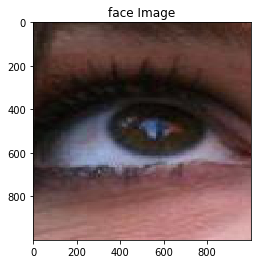

In [69]:
face = faces[0]
dim, width, height, channels = face.shape
imshow(face, 'face Image')
face = face.reshape(width, height, 3)
inp = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
inp = cv2.equalizeHist(inp)
inp = inp.reshape(width, height)
inp = cv2.resize(inp, (180,108))[np.newaxis, ..., np.newaxis]#algorithm needs 180x108
inp = inp.reshape(1, 108,180, 1)

In [79]:
input_array = np.concatenate([inp, inp], axis=0)
pred_left, _  = model.net.predict(input_array/255 * 2 - 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


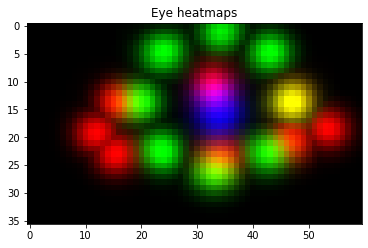

In [96]:
plt.title('Eye heatmaps')
hm_r = np.max(pred_left[...,:8], axis=-1, keepdims=True)
hm_g = np.max(pred_left[...,8:16], axis=-1, keepdims=True)
hm_b = np.max(pred_left[...,16:], axis=-1, keepdims=True)
plt.imshow(np.concatenate([hm_r, hm_g, hm_b], axis=-1))

In [97]:
def draw_pupil(im, inp_im, lms):
    draw = im.copy()
    draw = cv2.resize(draw, (inp_im.shape[2], inp_im.shape[1]))
    pupil_center = np.zeros((2,))
    pnts_outerline = []
    pnts_innerline = []
    stroke = inp_im.shape[1] // 12 + 1
    for i, lm in enumerate(np.squeeze(lms)):
        y, x = int(lm[0]*3), int(lm[1]*3)
        if i < 8:
            pnts_outerline.append([y, x])
        elif i < 16:
            pnts_innerline.append([y, x])
            pupil_center += (y,x)
    pupil_center = (pupil_center/8).astype(np.int32)
    draw = cv2.cv2.circle(draw, (pupil_center[0], pupil_center[1]), stroke, (255,0,0), 1, 8)        
    return draw

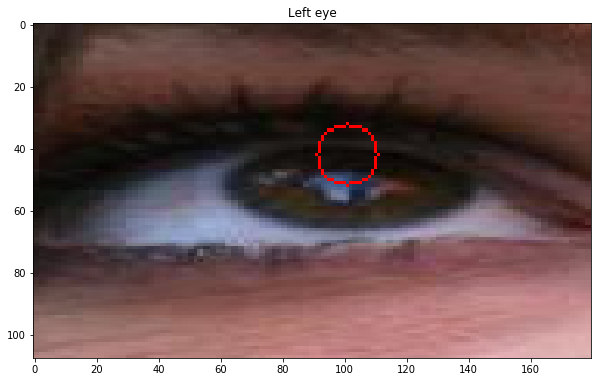

In [100]:
plt.figure(figsize=(10,10))
plt.title("Left eye")
lms_left = model._calculate_landmarks(pred_left)
result_left = draw_pupil(face, inp, lms_left)
plt.imshow(result_left)